In [247]:
import numpy as np
from qiskit import*
from scipy.sparse import identity
import numpy as np
from scipy import sparse
from scipy.sparse import lil_matrix
import scipy.sparse.linalg
import sys
from qiskit import*
#from qiskit import Aer
import qiskit.quantum_info as qi
import numpy as np
#from math import pi
#import matplotlib.pyplot as plt
import re

In [365]:
Target_state = '000000'
N = len(Target_state)


## The operator U_x.
A = np.ones((2**N, 2**N))
U_x = (2/(2**N))*A - np.identity(2**N, dtype = complex)


## The operator U_0. This is neeed for the sign adjustment of Grover_reconstructed operator.
U_0 = - np.identity(2 ** N, dtype=complex) 
Target_index = int(Target_state, 2)
U_0.itemset((Target_index, Target_index),1)


## G is the Grover operator.
G = np.matrix(np.matmul(U_x, U_0)) # U_w = U_x and U_s = U_0.

In [249]:
h = 1/np.sqrt(2)*np.matrix([[1,1],[1,-1]])
x = np.matrix([[0,1],[1,0]])
z = np.matrix([[1,0],[0,-1]])

In [250]:
h*x*h

matrix([[ 1.,  0.],
        [ 0., -1.]])

In [251]:
'''
Qiskit uses little endian notation, where the arrangement of the qubits are reversed.
The Kronecker product for the CNOT gate is modified according to the qiskit notation.
Counting starts from 0 and goes to N-1.

'''
def CNOT(c,t):
    
    '''
    Creating the matrix PI0 (|0><0|) and PI1 (|1><1|).
    
    '''
    I = np.identity(2)
    Z = np.matrix([[1,0],[0,-1]])
    X = np.matrix([[0,1],[1,0]])
    PI_0 = (I+Z)/2
    PI_1 = (I-Z)/2
    
    '''
    The following function returns the X gate for theta = pi. Any deviation from pi will
    result in a slightly different gate, which is used to model the noisy X gate.
    
    '''
    def Rx(theta):
        return np.around((np.cos(theta/2)*I-1j*X*np.sin(theta/2))*(np.cos(theta/2)*I+1j*I*np.sin(theta/2)),6)
    
    
    Matrices = {'I':I,'PI_0':PI_0,'X':X, 'PI_1':PI_1}
    
    
    '''
    
    We will first create two lists p0 and p1 (for PI0 and PI1) with the matrices
    of the Kronecker product of PI0 and PI1.
    
    '''
    p0 = ['I']*N
    p1 = ['I']*N
    
    
    '''
    The string will be modified according to the position of the target and the control qubits.
    
    '''

    for controls in c:
        p0[controls] = 'PI_0'        
        p1[controls] = 'PI_1'
    p1[t] = 'X'

    

    '''  
    Initialize the PI0 and PI1 matrices as the first elemenst of the list p0 and p1,
    then the following loop will perform the Kronecker product.
    
    '''    
    PI_0_matrix = Matrices[p0[0]]
    for i in range(1,N):
        PI_0_matrix = sparse.kron(Matrices[p0[i]],PI_0_matrix)
        
    PI_1_matrix = Matrices[p1[0]]
    for i in range(1,N):
        PI_1_matrix = sparse.kron(Matrices[p1[i]],PI_1_matrix)    
    
    
    #PI_0_Matrix = sparse.csr_matrix(np.zeros((2**N,2**N)))
    #for j in l:
        #PI0_temp = Matrices[j[0]]
        #for i in range(1,N):
            #PI0_temp = sparse.kron(Matrices[j[i]],PI0_temp)
        #PI_0_Matrix = PI_0_Matrix + PI0_temp
        
    #PI_1_Matrix = sparse.csr_matrix(np.zeros((2**N,2**N)))    
    #for j in m:
        #PI1_temp = Matrices[j[0]]
        #for i in range(1,N):
            #PI1_temp = sparse.kron(Matrices[j[i]],PI1_temp)

        #PI_1_Matrix = PI_1_Matrix + PI1_temp
    return PI_0_matrix+PI_1_matrix,p0,p1

In [252]:
def MCX(c,t):
    ## Changing the simulator 
    backend = Aer.get_backend('unitary_simulator')

    ## The circuit without measurement
    circ = QuantumCircuit(N)
    circ.mcx(c,t)

    ## job execution and getting the result as an object
    job = execute(circ, backend)
    result = job.result()

    ## get the unitary matrix from the result object
    return np.matrix(result.get_unitary(circ))

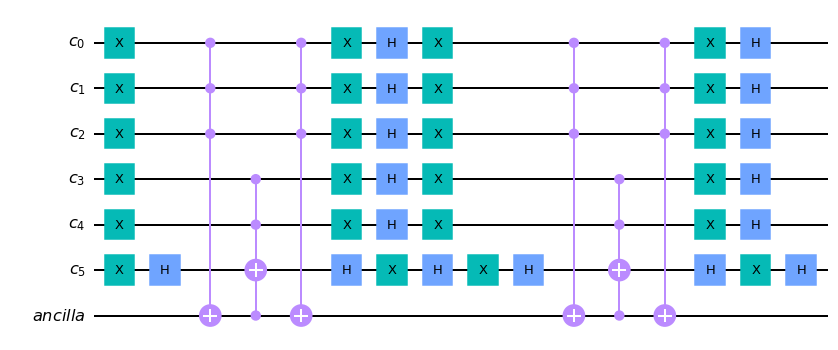

In [390]:
qr = QuantumRegister(6, 'c') # control qubits.
target_qubit = QuantumRegister(1,'t') # target qubit.
anc = QuantumRegister(1, 'ancilla') # ancilla qubits.
qc = QuantumCircuit(qr,anc)

#qc.h(qr[0])
#qc.h(qr[1])
#qc.h(qr[2])
#qc.h(qr[3])
#qc.h(qr[4])
#qc.h(qr[5])

# U_0 gate
qc.x(qr[0])
qc.x(qr[1])
qc.x(qr[2])
qc.x(qr[3])
qc.x(qr[4])
qc.x(qr[5])


qc.h(qr[5])
qc.mcx([qr[0],qr[1],qr[2]],anc[0])
qc.mcx([qr[3],qr[4],anc[0]],qr[5])
qc.mcx([qr[0],qr[1],qr[2]],anc[0])
#qc.mcx([qr[0],qr[1],qr[2],qr[3],qr[4]],qr[5])

qc.h(qr[5])

qc.x(qr[0])
qc.x(qr[1])
qc.x(qr[2])
qc.x(qr[3])
qc.x(qr[4])
qc.x(qr[5])
# U_0 gate


# CZ gate
qc.h(qr[0])
qc.h(qr[1])
qc.h(qr[2])
qc.h(qr[3])
qc.h(qr[4])
qc.h(qr[5])

qc.x(qr[0])
qc.x(qr[1])
qc.x(qr[2])
qc.x(qr[3])
qc.x(qr[4])
qc.x(qr[5])


qc.h(qr[5])
qc.mcx([qr[0],qr[1],qr[2]],anc[0])
qc.mcx([qr[3],qr[4],anc[0]],qr[5])
qc.mcx([qr[0],qr[1],qr[2]],anc[0])
#qc.mcx([qr[0],qr[1],qr[2],qr[3],qr[4]],qr[5])
qc.h(qr[5])

qc.x(qr[0])
qc.x(qr[1])
qc.x(qr[2])
qc.x(qr[3])
qc.x(qr[4])
qc.x(qr[5])

qc.h(qr[0])
qc.h(qr[1])
qc.h(qr[2])
qc.h(qr[3])
qc.h(qr[4])
qc.h(qr[5])
# CZ gate
qc.draw('mpl')

In [391]:
trans_qc = transpile(qc, basis_gates = ['id', 'rz', 'cx','h'], optimization_level = 3)

In [413]:
f[35]

(Instruction(name='h', num_qubits=1, num_clbits=0, params=[]),
 [Qubit(QuantumRegister(6, 'c'), 5)],
 [])

In [416]:
f[37]

(Instruction(name='h', num_qubits=1, num_clbits=0, params=[]),
 [Qubit(QuantumRegister(1, 'ancilla'), 0)],
 [])

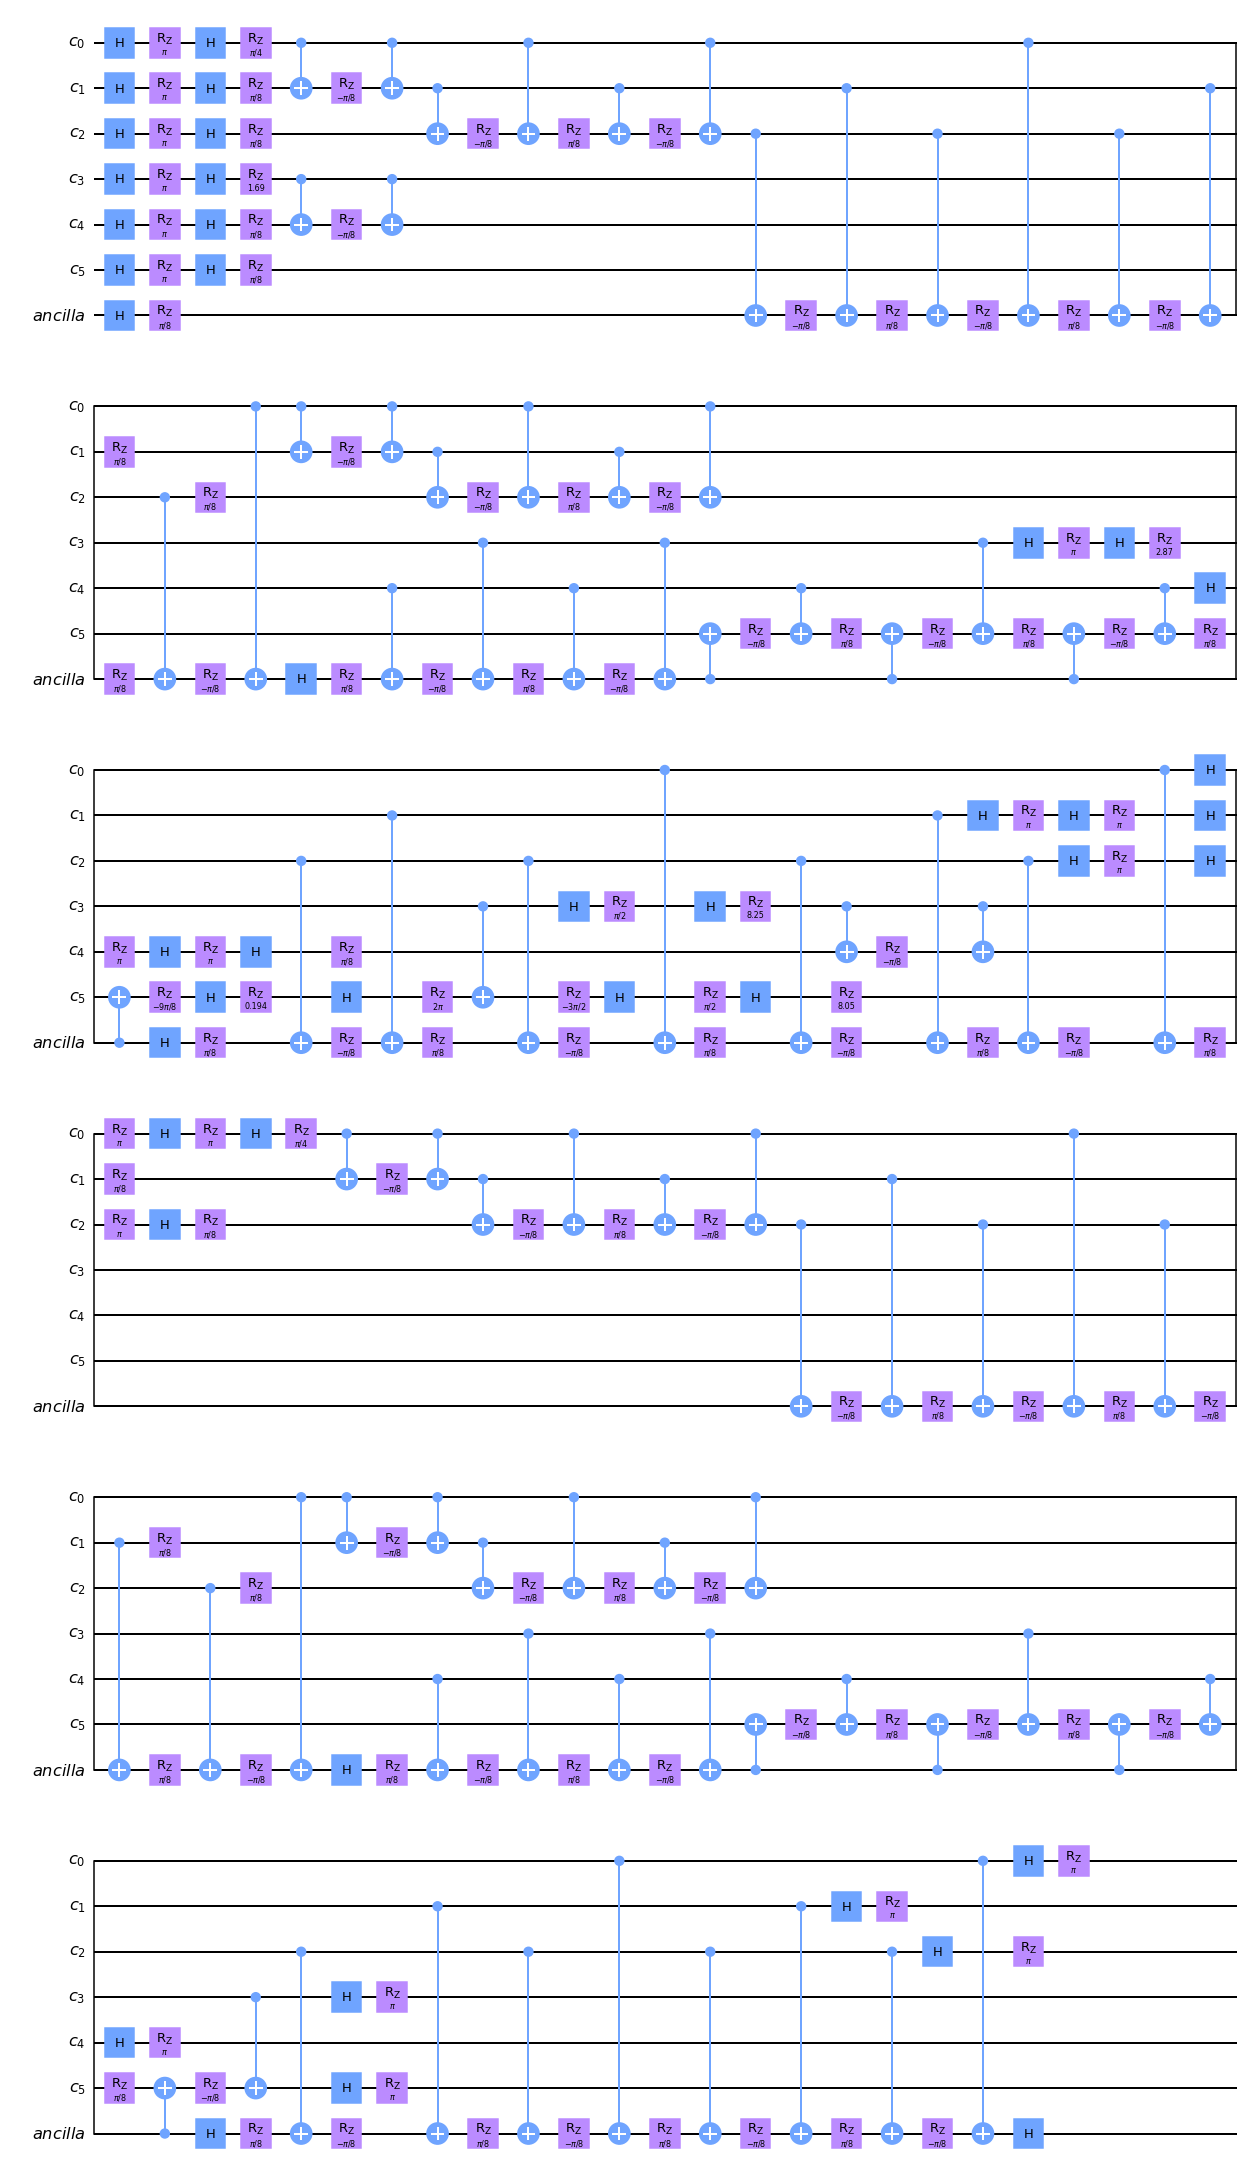

In [408]:
f = trans_qc
#len(f)
f.draw('mpl')

In [407]:


def List_Gates(Gate_Number):
    
    
    ## The list will hold string along with the angles in case of u3.
    l = []
    
    Name_of_Gate = []
    
    ## The list will hold the qubit in case of u3.
    Qubit = []    
    
    ## The list will hold the numerical value (float) of the angle in case of u3.
    Angle = []

    ## The following two lines will be used to separate the numerical value of the angle from 
    # a mixture of string and digits.
    numeric_const_pattern = '[-+]? (?: (?: \d* \. \d+ ) | (?: \d+ \.? ) )(?: [Ee] [+-]? \d+ )?'
    
    rx = re.compile(numeric_const_pattern, re.VERBOSE)
    
    if str(trans_qc[Gate_Number][0]).split(',')[0][-3:-1] == 'rz':
        
        Name_of_Gate.append('rz')        
        ## For the gate rz, there is one angle. The following lines puts the string which contain
        # the angle along with other alphabets in a list l.
        l.append(str(list(f)[Gate_Number]).split(',')[3])

        
        ## The following loop extracts the angle from the string of alphabet and digit.
        for i in l:
            
            if rx.findall(i) == []:
                
                ## the angle zero is written as 0.0 .
                Angle.append(0.0)
                
            else:
                
                Angle.append(float(rx.findall(i)[0]))
                
        ## the qubit on which rz acts is listed.        
        Qubit.append(re.sub("\D", "", str(trans_qc[Gate_Number][1]).split(',')[2]))  
        
    # For hadamard gates the qubit it is applied to is listed.    
    elif str(trans_qc[Gate_Number][0]).split(',')[0][-2:-1] == 'h':
        
        Name_of_Gate.append('h')
        Qubit.append(re.sub("\D", "", str(trans_qc[Gate_Number][1]).split(',')[2]))
    
    
        ## if the gate is cx then the Angle list is empty.        
    elif str(trans_qc[Gate_Number][0]).split(',')[0][-3:-1] == 'cx':
        
        Name_of_Gate.append('cx')     
        ## the control and the target bit is listed.
        Control_bit = re.sub("\D", '', str(trans_qc[Gate_Number][1][0]).split(',')[2])
        
        Target_bit = re.sub("\D", '', str(trans_qc[Gate_Number][1][1]).split(',')[2])   
        
        Qubit.append([Control_bit, Target_bit])
    
    
    return Name_of_Gate,Angle, Qubit



# The following list has all the gates in the format [name of the gate, angle, qubit].
l = []
for i in range(len(f)):
    l.append(List_Gates(i))      

## To view the gates, open the following text file.    
file = open('gates_list.txt', 'w')


## The following loop writes the gates into the file.
for i in range(len(l)):
    
    if l[i][0][0] == 'rz':
        
        file.write('rz'+','+str(l[i][1][0])+','+str(l[i][2][0])+','+'\n')

        
    elif l[i][0][0] == 'h':
        
        file.write('h'+','+'0.0'+','+str(l[i][2][0])+','+'\n')
        
        
    elif l[i][0][0] == 'cx':
        
        file.write('cx'+','+l[i][2][0][0]+','+l[i][2][0][1]+','+'\n')
file.close()

In [394]:
l = []

file1 = open('gates_list.txt', 'r')
Lines = file1.readlines()
 

for line in Lines:
    l.append(line.strip())

gates_list = []

for i in range(len(l)):
    
    l_temp = []
    gate_name = l[i].split(',')[0]
    gate_angle = l[i].split(',')[1]
    gate_qubit = l[i].split(',')[2]
    
    l_temp.append(gate_name)
    l_temp.append(gate_angle)
    l_temp.append(gate_qubit)

    gates_list.append(l_temp)

In [371]:
#N = 3
def Hadamard_gate(): # Hadamad gate acting on one qubit.
    
    return 1/np.sqrt(2)*np.array([[1,1],[1,-1]])

def RY(theta):
    return np.array([[np.cos(theta/2), -np.sin(theta/2)], [np.sin(theta/2), np.cos(theta/2)]])

def PauliZ():
    return np.array([[1,0],[0,-1]])

# H = RY(pi/2)*Z

def Hadamard(Angle, Qubit): 

    '''

    List below will hold gates acting on one qubit. For example, for L = 3,
    the Hadamard gate acting on the qubit 1 is given by = 1 x H x 1, where 
    x is the Kronecker product. Then, qubits_list = [1,H,1].

    ''' 

    qubits_list = [] 
    
    for i in range(N):
        
        if i == Qubit: # Qubit^th position in the list is H.
            
            qubits_list.append(np.matmul(RY(Angle),PauliZ()))
            
        else: # Other gates are identity operators.
            
            qubits_list.append(np.identity(2))

    '''
    
    The following loop performs the Kronecker product.

    '''        
    
    M = sparse.csr_matrix(qubits_list[0]) # Initializes the final matrix.
    
    for g in range(1,len(qubits_list)):
        
        M = sparse.kron(qubits_list[g],M) # kronecker product.
        
    return M

In [372]:
'''
Qiskit uses little endian notation, where the arrangement of the qubits are reversed.
The Kronecker product for the CNOT gate is modified according to the qiskit notation.
Counting starts from 0 and goes to N-1.

'''
def CNOT(c,t,theta):
    
    '''
    Creating the matrix PI0 (|0><0|) and PI1 (|1><1|).
    
    '''
    I = np.identity(2)
    Z = np.matrix([[1,0],[0,-1]])
    X = np.matrix([[0,1],[1,0]])
    PI_0 = (I+Z)/2
    PI_1 = (I-Z)/2
    
    '''
    The following function returns the X gate for theta = pi. Any deviation from pi will
    result in a slightly different gate, which is used to model the noisy X gate.
    
    '''
    def Rx(theta):
        return np.around((np.cos(theta/2)*I-1j*X*np.sin(theta/2))*(np.cos(theta/2)*I+1j*I*np.sin(theta/2)),12)
    
    
    Matrices = {'I':I,'PI_0':PI_0,'X':Rx(theta), 'PI_1':PI_1}
    
    
    '''
    
    We will first create two lists p0 and p1 (for PI0 and PI1) with the matrices
    of the Kronecker product of PI0 and PI1.
    
    '''
    p0 = ['I']*N
    p1 = ['I']*N
    
    
    '''
    The string will be modified according to the position of the target and the control qubits.
    
    '''
        
    p0[c] = 'PI_0'
    p1[c] = 'PI_1'
    p1[t] = 'X'

    

    '''  
    Initialize the PI0 and PI1 matrices as the first elemenst of the list p0 and p1,
    then the following loop will perform the Kronecker product.
    
    '''    
    
    
    
    PI_0_matrix = Matrices[p0[0]]
    for i in range(1,N):
        PI_0_matrix = sparse.kron(Matrices[p0[i]],PI_0_matrix)
        
    PI_1_matrix = Matrices[p1[0]]
    for i in range(1,N):
        PI_1_matrix = sparse.kron(Matrices[p1[i]],PI_1_matrix)

    return PI_0_matrix+PI_1_matrix

In [373]:
def Rz_matrix(theta):

    return np.matrix([[np.exp(-1j*theta/2),0],[0,np.exp(1j*theta/2)]])

def Rz(Angle, Qubit):
    
    if Qubit > N -1 :
        
        print("Qubit number exceeds N")
        
    else:    
    
        qubits_list = []
    
        for i in range(N):
        
            if i == Qubit:
            
                qubits_list.append(Rz_matrix(Angle))
            
            else:
            
                qubits_list.append(np.matrix(np.identity(2)))
    
        M = sparse.csr_matrix(qubits_list[0])
    
        for g in range(1,len(qubits_list)):
        
            M = sparse.kron(qubits_list[g], M) # kronecker product.
        
        return M

In [374]:
def Grover_reconstructed(epsilon):
    

    ## Initializing the oracle U_w as an identity matrix.
    
    Or = identity(2**N) 

    ## In the following loop we multiply all the 1 and 2 qubit gates with (or without) noise.
    
    
    for i in range(len(gates_list)): # l is the list with all the gates.
    
        if gates_list[i][0] == 'rz':
            
            Rz_s = Rz(float(gates_list[i][1])  +

                 epsilon * Rz_Noise[i], int(gates_list[i][2]))
            
            Or = Or*Rz_s
            
        
        
        
        elif gates_list[i][0] == 'h':
            
            
            Hs = Hadamard(np.pi/2+epsilon*Rz_Noise[i], int(gates_list[i][2]))
            Or = Or*Hs
            
        
        elif gates_list[i][0] == 'cx':

            Or = Or*CNOT(int(gates_list[i][1]), int(gates_list[i][2]),np.pi+epsilon*Rz_Noise[i])
     
    
    return Or.A

In [375]:
import numpy
import numpy.linalg

sigma_x=numpy.zeros((2,2),dtype=complex)
sigma_y=numpy.zeros((2,2),dtype=complex)
sigma_z=numpy.zeros((2,2),dtype=complex)
sigma_0=numpy.identity(2,dtype=complex)
sigma_x[0,1]=1.
sigma_x[1,0]=1.
sigma_y[0,1]=-1.j
sigma_y[1,0]=1.j
sigma_z[0,0]=1.
sigma_z[1,1]=-1.
sigma_plus=(sigma_x+1.j*sigma_y)/2.
sigma_minus=(sigma_x-1.j*sigma_y)/2.

def adjoint(psi):
    return psi.conjugate().transpose()

def psi_to_rho(psi):
    return numpy.outer(psi,psi.conjugate())

def exp_val(psi, op):
    return numpy.real(numpy.dot(adjoint(psi),op.dot(psi)))

def norm_sq(psi):
    return numpy.real(numpy.dot(adjoint(psi),psi))

def normalize(psi,tol=1e-9):
    ns=norm_sq(psi)**0.5
    if ns < tol:
        raise ValueError
    return psi/ns

def comm(a,b):
    return a.dot(b)-b.dot(a)

def anti_comm(a,b):
    return a.dot(b)+b.dot(a)

def is_herm(M,tol=1e-9):
    if M.shape[0]!=M.shape[1]:
        return False
    diff=M-adjoint(M)
    return max(numpy.abs(diff.flatten())) < tol

def is_unitary(M,tol=1e-9):
    if M.shape[0]!=M.shape[1]:
        return False
    diff=M.dot(adjoint(M))-numpy.identity((M.shape[0]))
    return max(numpy.abs(diff.flatten())) < tol

def eigu(U,tol=1e-9):
    (E_1,V_1)=numpy.linalg.eigh(U+adjoint(U))
    U_1=adjoint(V_1).dot(U).dot(V_1)
    H_1=adjoint(V_1).dot(U+adjoint(U)).dot(V_1)
    non_diag_lst=[]
    j=0
    while j < U_1.shape[0]:
        k=0
        while k < U_1.shape[0]:
            if j!=k and abs(U_1[j,k]) > tol:
                if j not in non_diag_lst:
                    non_diag_lst.append(j)
                if k not in non_diag_lst:
                    non_diag_lst.append(k)
            k+=1
        j+=1
    if len(non_diag_lst) > 0:
        non_diag_lst=numpy.sort(numpy.array(non_diag_lst))
        U_1_cut=U_1[non_diag_lst,:][:,non_diag_lst]
        (E_2_cut,V_2_cut)=numpy.linalg.eigh(1.j*(U_1_cut-adjoint(U_1_cut)))
        V_2=numpy.identity((U.shape[0]),dtype=V_2_cut.dtype)
        for j in range(len(non_diag_lst)):
            V_2[non_diag_lst[j],non_diag_lst]=V_2_cut[j,:]
        V_1=V_1.dot(V_2)
        U_1=adjoint(V_2).dot(U_1).dot(V_2)

    # Sort by phase
    U_1=numpy.diag(U_1)
    inds=numpy.argsort(numpy.imag(numpy.log(U_1)))

    return (U_1[inds],V_1[:,inds]) # = (U_d,V) s.t. U=V*U_d*V^\dagger

In [381]:
L = N // 2 # Length of half cut number of qubits.



'''
    The following function takes a wavefunction as input and returns its entropy.

'''

def Entropy(Wavefunction):




    # Converting the list to a numpy matrix.
    Psi = np.matrix(Wavefunction).reshape(len(Wavefunction),1) # Psi column matrix.

    # Normalizing Psi.
    Psi = Psi/np.linalg.norm(Psi)


      
    
    def psi(s):
        return Psi[(2**L)*s:(2**L)*s + 2**L]   
    
      
    '''
        psi(s_p) is a row matrix/vector. psi(s) is a column matrix/vector.      
        Dimension of rhoA is N/2 x N/2. 
        The element <s|rhoA|sp> is given by psi_sp^\dagger * psi_s.
        
    ''' 

    def rhoA(s,s_p): # <s|rho_A|s_p>

        # psi(s_p)^\dagger * psi(s) is the element of (s,s_p) of rho_AB.  
        return psi(s_p).getH() * psi(s)
    
    
    
    def rhoA_Matrix(N):
    
        M = np.zeros((N,N), dtype = complex) # 0 to N-1.
    
        '''
            rho is Hermitian, it is sufficient to calculate the elements above the diagonal.
            The the elements below the diagonal can be replace by the complex cpnjugate of the
            elements above the diagonal.
        '''
        for i in range(N):
            for j in range(N):
            
                if i <= j : # Above the diagonal (i,j) i<j.
                
                    M[i,j] = rhoA(i,j)[0,0]
                
                else: # Below the diagonal (i,j) i>j.
                
                    M[i,j] = np.conjugate(M[j,i])
        return M    
    
    
    '''
        w is the diagonal of the diagonalized matrix rhoA.

    '''
    
    w, v = np.linalg.eig(rhoA_Matrix(N))
    
    w = w.real

    '''
        The following loop calculates S = - sum \lamba_i * log(\lambda_i).

    '''
    
    DL = np.zeros(N) # Creating an array for log w with zeros.
    
    for i in range(len(w)):
    
        if abs(w[i]) < 1.e-8: # log of zero gives nan.
        
            pass # Leave the log(zero) element as zero.
    
        else:
        
            DL[i] = np.log(w[i])
        
    # Entropy = -Tr(rho * log(rho)).        
    return -sum(w*DL)




def Bin2Dec(BinaryNumber): # Converts binary to decimal numbers.
    return int(str(BinaryNumber),2)


def Dec2Bin(DecimalNumber): # Converts decimal to binary numbers.
    return bin(DecimalNumber).replace("0b", "")



List = [i for i in range(2**N)] 


'''
The following function converts all numbers in decimals in the above list 
 from 0 to 2^N -1 to binary.

''' 
def List_Bin(List):
    
    l = []
    
    for i in List:
        
        i_Bin = Dec2Bin(i)
              
        
        '''
        While converting numbers from decimal to binary, for example, 1
         is mapped to 1, to make sure that
        every numbers have N qubits in them, the following loop adds leading 
        zeros to make the
        length of the binary string equal to N. Now, 1 is mapped to 000.....1
         (string of length N).
        
        '''
        
        while len(i_Bin) < N: 
            
            i_Bin = '0'+i_Bin # This loop adds leading zeros.
            
        l.append(i_Bin)
        
    return l





'''
    The following function takes a binary string as input and rolls the qubits by one and
    returns the rolled string.

'''

def Roll_String(Binary_String):
    
    return Binary_String[-1] + Binary_String[:-1]







'''
    The following function takes a wavefunction as input and performs one roll
     on the qubits and
    returns the resultant wavefunction.

'''

def Psi_Roll(Inital_Psi):
    
    
    
    '''
        The following list contains all possible 2^N qubits after one roll 
        is performed on them.
        For example, the first position 0001 is changed to 1000.
    
    '''
    
    # Rolls every string in the list List by one qubit.
    Rl = [Roll_String(i) for i in List_Bin(List)] 

   

    
    ''' 
        The following list contains the previous list but in decimal numbers. For example,
        for N =4, the first position 1 is changed to 8.
        
    
    '''
    
    Rl_d = [Bin2Dec(i) for i in Rl] # Converts the rolled binary string to decimal number.


    '''
        The following loop rearranges the coefficients of Psi after rolling. 
        For example, for N = 4,
        if the first coefficient 0001 is mapped to the eighth coefficient 1000 after
         one rotation of
        the qubits. The coefficient of the rolled Psi in the i ^ th position is in the
         Rl_d[i] ^ th positon
        of the initial Psi.
    
    '''
    
    
    Psi_Rolled = []

    for i in range(2**N): 
        # Rearranging the coefficients according to the list l_d.
        Psi_Rolled.append(Inital_Psi[Rl_d[i]]) 
        
    return Psi_Rolled


'''
    The following function performs specified number of rolls Num on the qubits.

'''

def N_Rolled(Num, Initial_Psi): # Use loop only for postive N.
    
    if Num == 0:
        
        return Initial_Psi
    
    else:
    
        s = Psi_Roll(Initial_Psi) # One roll.
    
        for i in range(Num-1): # Loop performing remaining N-1 rolls.
        
            s = Psi_Roll(s)
        
        return np.matrix(s).reshape(2**N,1) # Returning the rolled wavefunction as a matrix.

def Average_Entropy(Initial_Psi):
    
    list_of_entropies = []
    
    '''
    The loop calculates all the entropies and returns a list containing them.
    
    '''
    for i in range(N):
        
        S = Entropy(N_Rolled(i, Initial_Psi))
        list_of_entropies.append(S)
        
    # Returns the average entropy    
    return sum(list_of_entropies) / len(list_of_entropies)


def V_Matrix(operator):
    return eigu(operator)[1]
    
def Array2List(Arr):
    Arr_l = Arr.tolist()
    l = []
    for i in Arr_l:
        l.append(i[0])
    return l

In [376]:
def Phi_F(operator): 
    
    return (1j*np.log(eigu(operator)[0])).real  # eigu(Gr)[0] = exp(-i * phi_F)

In [377]:
np.random.seed(2022)
Rz_Noise = 2*(np.random.rand(len(gates_list))-0.5)

In [395]:
Op = Grover_reconstructed(0.0)

In [396]:
Phi_F(Op)

array([ 2.37081759,  2.37081759,  2.37081759,  2.37081759,  2.37081759,
        2.37081759,  2.29853695,  2.29853695,  2.29853695,  2.29853695,
        2.29853695,  2.29853695,  1.84880762,  1.71078029,  1.64814519,
        1.64814519,  1.64814519,  1.64814519,  1.64814519,  1.64814519,
        1.63127861,  1.47323405,  1.46691213,  1.43944651,  1.43944651,
        1.43944651,  1.43944651,  1.43944651,  1.43944651,  1.40220971,
        1.40220971,  1.40220971,  1.40220971,  1.40220971,  1.40220971,
        1.32813718,  1.26282901,  1.22756629, -0.58802496, -0.58802496,
       -0.58802496, -0.58802496, -0.58802496, -0.58802496, -1.01737084,
       -1.08695834, -1.13267418, -1.29189399, -1.48294839, -1.48294839,
       -1.48294839, -1.48294839, -1.48294839, -1.48294839, -1.49665683,
       -1.49752287, -1.64270997, -1.67166948, -1.67166948, -1.67166948,
       -1.67166948, -1.67166948, -1.67166948, -1.82763759])

In [385]:
f = open('plot_data'+Target_state+'.txt', 'w')

Num = 400
for i in range(1,Num):
    eps = 0.25*(i/(Num))
    print(i)
    
    f = open('plot_data'+Target_state+'.txt', 'a')
    Op = Grover_reconstructed(eps)
    X = str(eps)
    Y = Phi_F(Op)
    V = eigu(Op)[1]
            
    # file -> epsilon phi_f entropy    
    for j in range(2**N):
        f.write(X +'\t'+ str(Y[j].real)+ '\t' + str(Average_Entropy(Array2List(V[:,j:j+1]))) +'\n')   

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
